## QVMC Intro
Using the Illinois tutorial - https://clark.physics.illinois.edu/Tutorials/VMCIntroTutorial/index.html
Hydrogen molecule - one spin up, one spin down.

In [56]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
def modulo(x):
    return sum([i**2 for i in x])

def euclidean_distance(r1, r2):

    dist = 0
    for i in range(len(r1)):
        dist += (r1[i] - r2[i]) ** 2
    
    return np.sqrt(dist) 

### Trial Wavefunction 1 - Gaussian with a variational width

In [4]:
def psi(coords, ions=None, alpha=0.5):
    return math.exp(- alpha * (modulo(coords[0]) + modulo(coords[1])))

### Accepting and rejecting moves

In [5]:
def VMC(WF, ions, numSteps):

    ratios = []
    coords_arr = []

    R = np.zeros((2, 2), float)
    movesAttempted = 0.0
    movesAccepted = 0.0
    coords = np.zeros((2, 3))
    original_WF = WF(coords, ions)
    for step in range(numSteps):
        for ptcl in range(len(R)):
            a = 5  # Define movement parameters
            # Implement move for particle 'ptcl'
            delta = 1
            move_coords = delta * 1.5 * np.random.rand(3)
            move_coords[2] = 0
            new_coords = coords.copy()

            if random.random() <= 0.5:
                new_coords[ptcl] += move_coords
            else:
                new_coords[ptcl] -= move_coords
            
            new_WF = WF(new_coords, ions)

            if new_WF:
                
                ratio = (new_WF / original_WF) ** 2

                if random.random() <= ratio:
                    movesAccepted += 1
                    coords_arr.append(new_coords[ptcl])
                    #coords = new_coords.copy()
                    #original_WF = new_WF
                
                ratio = min(1, ratio)
                ratios.append(ratio)

            movesAttempted += 1
            
    print("Acceptance ratio:", movesAccepted/movesAttempted)
    return coords_arr

In [6]:
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])
coords_arr = VMC(psi, ions=ions, numSteps=10000)

Acceptance ratio: 0.3221


In [7]:
coords_x = [i[0] for i in coords_arr]

Text(0.5, 1.0, 'Electron density along x')

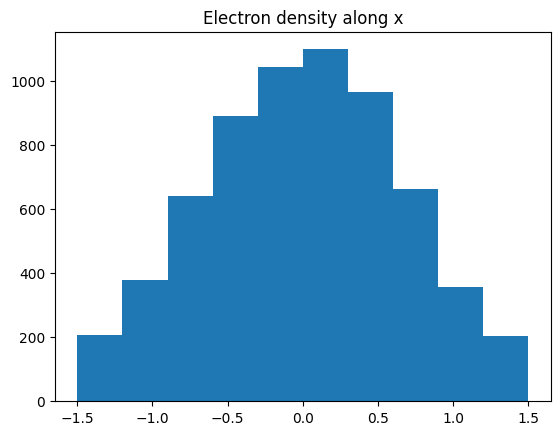

In [8]:
plt.hist(coords_x)
plt.title("Electron density along x")

### Local energy

In [36]:
def LaplacianPsiOverPsi(wavefunction, coords, alpha, ions=None, delta=1e-5):
    return (wavefunction(coords +  delta, alpha=alpha) - 2 * wavefunction(coords, alpha=alpha) + wavefunction(coords - delta, alpha=alpha)) / delta ** 2

def LocalEnergy(wavefunction, coords, ions, alpha):

    kinetic_energy = - LaplacianPsiOverPsi(wavefunction, coords, alpha)
    #print(kinetic_energy)

    ion_electron_potential = 0

    for i in coords:
        for j in ions:
            ion_electron_potential += 1 / euclidean_distance(i, j)

    electron_electron_potential = 1 / (euclidean_distance(coords[1], coords[0]))

    ion_ion_potential = 1 / (euclidean_distance(ions[0], ions[1]))

    """
    print(f"Electron potential {electron_electron_potential}\n"
          f"Ion potential {ion_ion_potential}\n"
          f"Ion electron potential {ion_electron_potential}\n"
          f"Kinetic energy {kinetic_energy}"
          )
    """

    potential_energy = electron_electron_potential + ion_ion_potential - ion_electron_potential


    return potential_energy + kinetic_energy

In [37]:

R = np.zeros((2,3), float)
R[0] = [1.0, 0.3, 0.2]
R[1] = [2.0, -0.2, 0.1]

# Set your ions so that the bond length is 1.4
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])

print(LocalEnergy(psi, R, ions))

TypeError: LocalEnergy() missing 1 required positional argument: 'alpha'

In [60]:

# Local energy addition

def VMC_energy(WF, ions, numSteps, alpha):
    
    energies = []
    R = np.zeros((2, 2), float)
    movesAttempted = 0.0
    movesAccepted = 0.0
    coords = np.zeros((2, 3))

    original_WF = WF(coords, ions, alpha)
    for step in range(numSteps):
        for ptcl in range(len(R)):
            a = 5  # Define movement parameters
            # Implement move for particle 'ptcl'
            delta = 1
            move_coords = delta * 1.5 * np.random.rand(3)
            move_coords[2] = 0
            new_coords = coords.copy()
            new_coords[ptcl] += move_coords
            new_WF = WF(new_coords, ions, alpha)

            if new_WF:
                
                ratio = (new_WF / original_WF) ** 2

                if random.random() <= ratio:
                    movesAccepted += 1
                    #coords = new_coords.copy()
                    #original_WF = new_WF
                    E = LocalEnergy(WF, new_coords, ions, alpha)
                    energies.append(E)
                ratio = min(1, ratio)

            movesAttempted += 1
            
    print("Acceptance ratio:", movesAccepted/movesAttempted)
    return energies

In [61]:
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])
energies = VMC_energy(psi, ions=ions, numSteps=10000, alpha=0.5)

Acceptance ratio: 0.3232


In [54]:
np.mean(energies)

np.float64(0.1156419336717569)

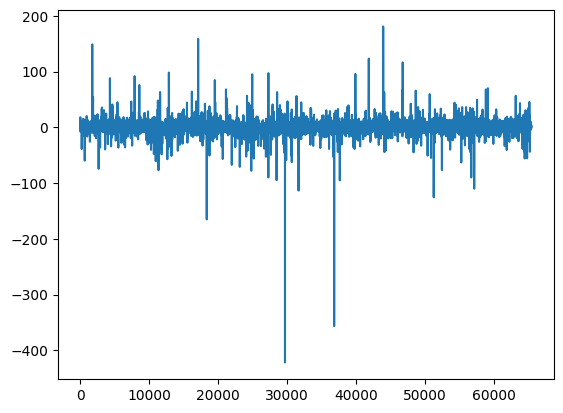

In [35]:
plt.plot(energies)

In [40]:
# Vary the local energy as we accept new positions - and then vary the parameter as well
np.min(energies)

np.float64(-421.61227528045833)

In [41]:
np.mean(energies)

np.float64(0.24284760346474515)

In [ ]:
# Marching alpha

energies = []

for alpha in tqdm(np.arange(0.0, 1.0, 0.01)):
    local_energy_arr = VMC_energy(psi, ions=ions, numSteps=10000, alpha=alpha)
    energies.append(np.mean(local_energy_arr))

  0%|          | 0/20 [00:00<?, ?it/s]

Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 1.0
Acceptance ratio: 0.7546
Acceptance ratio: 0.58445
Acceptance ratio: 0.47215
Acceptance ratio: 0.3883
Acceptance ratio: 0.32195
Acceptance ratio: 0.2773
Acceptance ratio: 0.24675
Acceptance ratio: 0.21795
Acceptance ratio: 0.19155


In [65]:
energies

[np.float64(-226.15156672561426),
 np.float64(-146.83409755426496),
 np.float64(-96.3333000362069),
 np.float64(-62.53774141001517),
 np.float64(-40.311183991662695),
 np.float64(-26.161152501999315),
 np.float64(-16.945063047308995),
 np.float64(-11.03587835656732),
 np.float64(-7.183497171553352),
 np.float64(-4.74715923403077),
 np.float64(-3.2075251649254723),
 np.float64(-2.2440901236223145),
 np.float64(-1.5651114447717587),
 np.float64(-0.9417590369218478),
 np.float64(-0.35578809853681376),
 np.float64(0.24569576064677603),
 np.float64(0.8764601926586844),
 np.float64(1.5324394245515143),
 np.float64(2.4050736675542463),
 np.float64(3.075724634728353)]